# Data Ingestion and Preprocessing

It can be seen that each json file represents a monthly data of AAVAIL's transaction for different countries. The various features availabe in the data are "TimesViewed", "country", "customer_id", "day", "invoice", "month", "total_price" and "year" alongwith a unique stream id. These can be used to create a dataframe which will then be used to merge all data of all the months to create one single dataframe.

In [1]:
# Import packages and modules
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Data Ingestion and Preprocessing
from data_ingestor import fetch_data
df_total = pd.DataFrame()

data_dir = os.path.join("..","data","cs-train")
df_total = fetch_data(data_dir)

print(df_total.shape)
df_total.head()

(815011, 10)


,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
0,United Kingdom,13085.0,28,489434,11,6.95,85048,12,2017,2017-11-28
1,United Kingdom,13085.0,28,489434,11,6.75,79323W,12,2017,2017-11-28
2,United Kingdom,13085.0,28,489434,11,2.10,22041,21,2017,2017-11-28
3,United Kingdom,13085.0,28,489434,11,1.25,21232,5,2017,2017-11-28
4,United Kingdom,13085.0,28,489434,11,1.65,22064,17,2017,2017-11-28


Data type of data in all the columns is checked in order to make sure further steps can be carried out with ease

In [4]:
df_total.dtypes

country                 object
customer_id            float64
day                      int64
invoice                 object
month                    int64
price                  float64
stream_id               object
times_viewed             int64
year                     int64
invoice_date    datetime64[ns]
dtype: object

In [5]:
# See if price is negative. If yes, remove
df_total[df_total['price'] < 0]

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
180418,United Kingdom,NaN,26,506401,4,-53594.36,B,1,2018,2018-04-26
276274,United Kingdom,NaN,16,516228,7,-44031.79,B,1,2018,2018-07-16
403469,United Kingdom,NaN,17,528059,10,-38925.87,B,1,2018,2018-10-17


Clean the data by dropping rows where invoice id is not a number in order to facilitate better matching. Though it was handled during data ingestion, make sure we don't have any left.

In [6]:
df_clean = df_total[~df_total['invoice'].str.contains("[a-zA-Z]").fillna(False)]
df_clean.shape

(815011, 10)

In [7]:
df_clean = df_clean[df_clean['price'] >= 0]
df_clean.shape

(815008, 10)

In [8]:
# Number of unique invoice ids
df_clean['invoice'].nunique()

42643

# Exploratory Data Analysis

Quality Assurance Steps:
1. Remove any repeat customers based on customer_id
2. Check for missing values

In [9]:
print("\nCleaning Summary\n{}".format("-"*35))
print("Total records:", df_clean.shape[0])
duplicate_rows = df_clean.duplicated()
if True in duplicate_rows:
    df_clean = df_clean[~duplicate_rows]
print("Removed {} duplicate rows".format(np.where(duplicate_rows==True)[0].size))

print("\nMissing Value Summary\n{}".format("-"*35))
print("\ndf_clean\n{}".format("-"*15))
print(df_clean.isnull().sum(axis = 0))


Cleaning Summary
-----------------------------------
Total records: 815008
Removed 28844 duplicate rows

Missing Value Summary
-----------------------------------

df_clean
---------------
country              0
customer_id     182191
day                  0
invoice              0
month                0
price                0
stream_id            0
times_viewed         0
year                 0
invoice_date         0
dtype: int64


Look for the countries with higher revenues.  'United Kingdom' has highest revenue

In [10]:
df_rev = df_clean[['country', 'price']].groupby('country').sum().sort_values('price', ascending=False)
df_rev = df_rev.rename(columns={'price': 'revenue'})
df_rev_by_country = df_rev.reset_index()
print("Top 10 Countries in terms of Revenue")
print(df_rev.shape)
df_rev[:10]

Top 10 Countries in terms of Revenue
(43, 1)


,revenue
country,
United Kingdom,3.518516e+06
EIRE,1.062234e+05
Germany,4.835679e+04
France,3.966539e+04
Norway,3.833638e+04
Spain,1.589153e+04
Hong Kong,1.444137e+04
Portugal,1.318820e+04
Singapore,1.317592e+04


In [11]:
df_clean['country'].value_counts()

United Kingdom          723321
EIRE                     13432
Germany                  13123
France                    9669
Netherlands               4022
Spain                     2557
Switzerland               2320
Belgium                   2159
Portugal                  1734
Australia                 1525
Channel Islands           1270
Sweden                    1155
Italy                     1025
Cyprus                     898
Finland                    749
Norway                     736
Austria                    719
Greece                     627
Denmark                    617
Unspecified                611
Japan                      501
United Arab Emirates       462
Poland                     425
Singapore                  310
Hong Kong                  274
USA                        266
Canada                     223
Malta                      219
Lithuania                  173
Iceland                    167
Israel                     139
Bahrain                    126
RSA     

In [12]:
## Total Unique Invoices
df_clean['invoice'].value_counts()

558475    705
537434    689
538071    658
538349    620
537237    609
         ... 
507934      1
554377      1
520200      1
533814      1
542574      1
Name: invoice, Length: 42643, dtype: int64

There are quite few records for several countries with least revenues. So it would be better to get a subset of top 10 countries with highest revenue.  Perform further investigation based on this subset

In [13]:
## Subset of only top 10 countries for plots
list_top_10 = ['United Kingdom', 'EIRE', 'Germany', 'France',
               'Norway', 'Spain', 'Hong Kong', 'Portugal',
               'Singapore', 'Netherlands']
df_top = df_clean[df_clean['country'].isin(list_top_10)]
df_top.shape

(769178, 10)

### Visualization

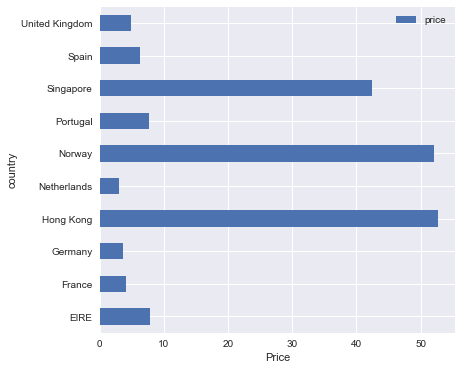

In [14]:
fig = plt.figure(figsize=(14,6))
ax2 = fig.add_subplot(121)

table2 = pd.pivot_table(df_top, index = ['country'], values = 'price')
table2.plot(kind='barh',ax=ax2)
ax2.set_xlabel("Price");

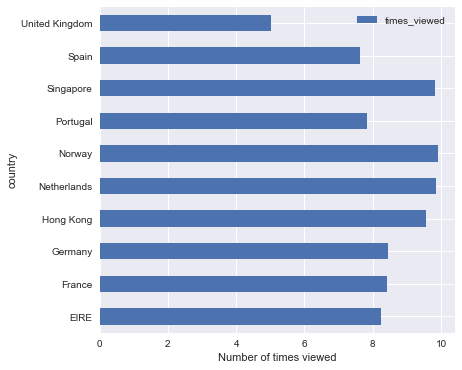

In [15]:
fig = plt.figure(figsize=(14,6))
ax2 = fig.add_subplot(121)

table2 = pd.pivot_table(df_top, index = ['country'], values = 'times_viewed')
table2.plot(kind='barh',ax=ax2)
ax2.set_xlabel("Number of times viewed");

(0, 120)

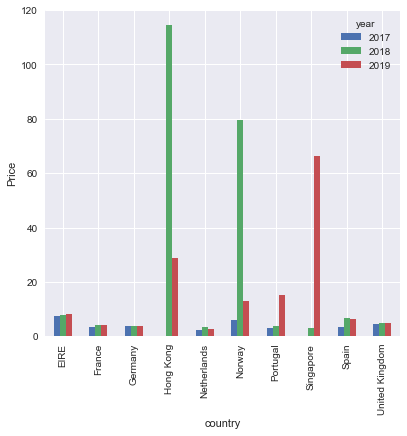

In [19]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)

table1 = pd.pivot_table(df_top,index='country',columns='year',values="price")
table1.plot(kind='bar',ax=ax1)
ax1.set_ylabel("Price")
ax1.set_ylim((0,120))

(0, 12)

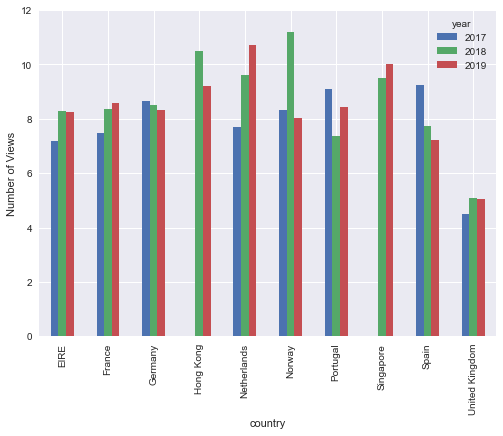

In [20]:
fig = plt.figure(figsize=(18,6))
ax2 = fig.add_subplot(121)

table2 = pd.pivot_table(df_top,index='country',columns='year',values="times_viewed")
table2.plot(kind='bar',ax=ax2)
ax2.set_ylabel("Number of Views")
ax2.set_ylim((0,12))

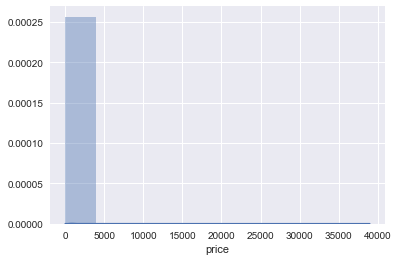

In [21]:
sns.distplot(df_top['price'], bins=10)
plt.show()

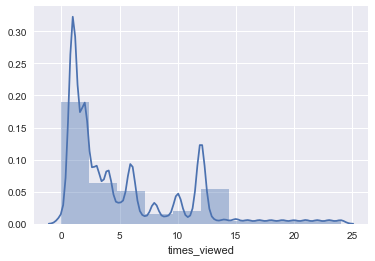

In [22]:
sns.distplot(df_top['times_viewed'], bins=10)
plt.show()

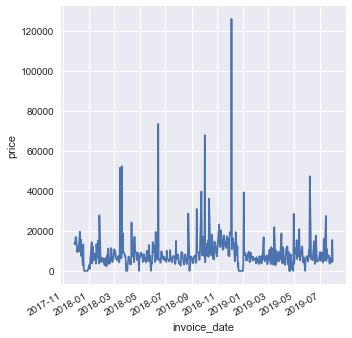

In [23]:
g = sns.relplot(x='invoice_date', y='price', data=df_top.groupby(pd.Grouper(key='invoice_date', freq='B')).sum().reset_index(), kind='line')
g.fig.autofmt_xdate()

In order to carry out a time series analysis, record of each day should be considered and the dataframe should be in a chronological order so that forecasting models can fit and provide revenue i.e price for the following month. Let's start by aggregating the transactions by day

In [24]:
df_agg = df_top.groupby(['invoice_date']).agg({'times_viewed':'sum', 'price':'sum',
                                        'country':'first',}).reset_index()
df_agg.head()

,invoice_date,times_viewed,price,country
0,2017-11-28,14859,14058.96,United Kingdom
1,2017-11-29,14073,13285.86,United Kingdom
2,2017-11-30,15534,13193.71,United Kingdom
3,2017-12-01,12065,9421.20,United Kingdom
4,2017-12-02,3101,1263.28,United Kingdom


In [25]:
print("Total number of days in considerdation for analysis:", df_agg.shape[0])

Total number of days in considerdation for analysis: 495


In [26]:
print(df_agg.head(1))
print(df_agg.tail(1))

  invoice_date  times_viewed     price         country
0   2017-11-28         14859  14058.96  United Kingdom
    invoice_date  times_viewed   price         country
494   2019-07-31          9359  4854.0  United Kingdom
